# Traffic sign detection and classification

In [1]:
from xml.dom import minidom
from os import walk
import pandas as pd
import cv2 as cv
import numpy as np
from sklearn import metrics
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filenames = next(walk("res/annotations"), (None, None, []))[2]  # [] if no file

signs = []

for annotation in filenames:
    file = minidom.parse("res/annotations/" + annotation)
    if len(file.getElementsByTagName('name')) == 1:
        path = "res/images/" + file.getElementsByTagName('filename')[0].firstChild.data
        filename = file.getElementsByTagName('filename')[0].firstChild.data
        name = file.getElementsByTagName('name')[0].firstChild.data

        if name == "trafficlight":
            continue

        signs.append([filename, name, path])

df = pd.DataFrame(signs, columns=['filename', 'name', 'path'])

In [3]:
def condition_classes(s):
    if s['name'] == 'speedlimit':
        return 0
    elif s["name"] == 'crosswalk':
        return 1
    elif s["name"] == "stop":
        return 2


df["class"] = df.apply(condition_classes, axis=1)

In [4]:
def concatenate_and_write(row):
    img = cv.imread(row.path)
    hist = cv.imread("output/histogram/" + row.filename)
    segm = cv.imread("output/segmentation/" + row.filename)
    post = cv.imread("output/post_processing/" + row.filename)
    anno = cv.imread("output/connected_component/" + row.filename)

    vis = np.concatenate((img, hist, segm, anno, post), axis=1)

    cv.imwrite("output/concatenated/" + row.filename, vis)

## Step 1 - Histogram equalization

In [5]:
def apply_histogram_equalization(row):
    img = cv.imread(row.path)
    lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)

    clahe = cv.createCLAHE(clipLimit=10.0,tileGridSize=(8,8))

    lab[...,0] = clahe.apply(lab[...,0])

    out = cv.cvtColor(lab, cv.COLOR_LAB2BGR)

    cv.imwrite("output/histogram/" + row.filename, out)

In [6]:
df.apply(apply_histogram_equalization, axis=1);

## Step 2 - Segmentation by Color

In [7]:
def apply_segmentation(row):
    img = cv.imread(row.path)
    # TODO - work on histogram equalization
    img_hist = cv.imread("output/histogram/" + row.filename)
    img_hsv = cv.cvtColor(img_hist, cv.COLOR_BGR2HSV)

    lower_red_m1 = (0, 70, 60)
    upper_red_m1 = (10, 255, 255)

    lower_red_m2 = (170, 70, 60)
    upper_red_m2 = (180, 255, 255)

    lower_blue_m3 = (94, 127, 20)
    upper_blue_m3 = (126, 255, 200)

    mask1 = cv.inRange(img_hsv, lower_red_m1, upper_red_m1)
    mask2 = cv.inRange(img_hsv, lower_red_m2, upper_red_m2)
    mask3 = cv.inRange(img_hsv, lower_blue_m3, upper_blue_m3)

    mask = mask1 + mask2 + mask3

    # out = cv.bitwise_and(img_hist, img_hist, mask=mask)

    cv.imwrite("output/segmentation/" + row.filename, mask)

In [8]:
df.apply(apply_segmentation, axis=1);

## Step 3 - Post-Processing

In [9]:
def apply_post_processing(row):
    img = cv.imread(row.path)
    segm_img = cv.imread("output/segmentation/" + row.filename, cv.IMREAD_GRAYSCALE)

    # apply median filter to remove noise
    out = cv.medianBlur(segm_img, 5)
    rows, cols = out.shape
    
    # Taking a matrix of size 5 as the kernel
    kernel = np.ones((5, 5), np.uint8)

    # morphological operations
    out = cv.morphologyEx(out, cv.MORPH_CLOSE, kernel, iterations=3)

    # remove small and weird objects
    contours, hierarchy = cv.findContours(out, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[-2:]
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        aspect_ratio = float(w) / h
        if cv.contourArea(contour) < 1 / 1500.0 * rows * cols and (aspect_ratio > 0.5 or aspect_ratio < 1.3):
            out = cv.fillPoly(out, pts=contour, color=(0, 0, 0))

    mask = np.full(img.shape, 0, "uint8")
    contours, hierarchies = cv.findContours(out, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[-2:]
    for cnt in contours:
        cv.drawContours(mask, [cnt], -1, (255, 255, 255), -1)

    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    # morphological operations
    out = cv.erode(mask, kernel, iterations=1)
    # out = cv.dilate(out, kernel, iterations=1)

    cv.imwrite("output/post_processing/" + row.filename, out)

In [10]:
df.apply(apply_post_processing, axis=1);

## Step 4 - Find Connected Components

In [11]:
def connected_component(row):
    original = cv.imread(row.path)
    img = cv.imread('output/segmentation/' + row.filename, 0)
    # apply median filter to remove noise
    img = cv.medianBlur(img, 5)
    
    output = cv.connectedComponentsWithStats(img, 4, cv.CV_32S)
    (numLabels, labels, stats, centroids) = output
    
    output = original.copy()
    
    components = []
    
    # loop over the number of unique connected component labels
    for i in range(0, numLabels):
        # background
        if i == 0:
            continue
        
        x = stats[i, cv.CC_STAT_LEFT]
        y = stats[i, cv.CC_STAT_TOP]
        w = stats[i, cv.CC_STAT_WIDTH]
        h = stats[i, cv.CC_STAT_HEIGHT]
        area = stats[i, cv.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        
        if 0.8 > float(w)/h or float(w)/h > 1.3:
            continue
        
        components.append((x,y,w,h,cX,cY))
        
        cv.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
        
        
    cv.imwrite('output/connected_component/' + row.filename, output)
    
    return sorted(components, key=lambda x: x[2]*x[3])[:4]
    

In [12]:
df["components"] = df.apply(connected_component, axis=1);

In [13]:
df.apply(concatenate_and_write, axis=1);

## Step 4 - Shape Recognition

In [14]:
def shape_recognition(row):
    img = cv.imread(row.path)
    processed = cv.imread("output/post_processing/" + row.filename, 0)

    _, thresh = cv.threshold(processed, 240, 255, cv.CHAIN_APPROX_NONE)
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[-2:]

    contours = sorted(contours, key=lambda x: -cv.contourArea(x))[:10]

    shapes = []

    for contour in contours:
        if float(cv.contourArea(contour) / (img.shape[0]*img.shape[1])) >= 0.95:
            continue
        approx = cv.approxPolyDP(contour, 0.01*cv.arcLength(contour, True), True)
        if len(approx) == 4:
            shapes.append(("rectangle", cv.contourArea(contour), (cv.boundingRect(contour))))
        elif len(approx) == 8:
            shapes.append(("octagon", cv.contourArea(contour), (cv.boundingRect(contour))))
        elif len(approx) > 8:
            shapes.append(("circle", cv.contourArea(contour), (cv.boundingRect(contour))))

    return shapes

In [15]:
df["shapes"] = df.apply(shape_recognition, axis=1);

In [16]:
def process_roi_blue(mask_blue):
    linesP = cv.HoughLinesP(mask_blue, 1, np.pi / 180, 50, None, 50, 10)

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv.line(mask_blue, (l[0], l[1]), (l[2], l[3]),
                    (255, 0, 255), 3, cv.LINE_AA)
    
    # blue 
    # apply median filter to remove noise
    out = cv.medianBlur(mask_blue, 5)
    rows, cols = out.shape

    # Taking a matrix of size 5 as the kernel
    kernel = np.ones((10, 10), np.uint8)

    # morphological operations
    out = cv.morphologyEx(out, cv.MORPH_CLOSE, kernel, iterations=4)

    return out

In [17]:
def process_roi_red(mask_red):
    # apply median filter to remove noise
    out = cv.medianBlur(mask_red, 5)
    rows, cols = out.shape

    # Taking a matrix of size 5 as the kernel
    kernel = np.ones((10, 10), np.uint8)

    # morphological operations
    out = cv.morphologyEx(out, cv.MORPH_CLOSE, kernel, iterations=3)

    return out

In [18]:
def process_roi(filename, roi):
    x,y,w,h,cX,cY = roi
    
    img = cv.imread('output/histogram/' + filename)
    img = img[y:(y+h),x:(x+w)]
    
    aux = np.full((h+50, w+50, 3), 0, "uint8")
    aux[25:25+h, 25:25+w] = img
    img = aux
    
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    lower_red_m1 = (0, 70, 60)
    upper_red_m1 = (10, 255, 255)

    lower_red_m2 = (170, 70, 60)
    upper_red_m2 = (180, 255, 255)

    lower_blue_m3 = (94, 127, 20)
    upper_blue_m3 = (126, 255, 200)

    mask1 = cv.inRange(img_hsv, lower_red_m1, upper_red_m1)
    mask2 = cv.inRange(img_hsv, lower_red_m2, upper_red_m2)
    mask_red = mask1 + mask2
    
    mask_blue = cv.inRange(img_hsv, lower_blue_m3, upper_blue_m3)

    ratio_red = cv.countNonZero(mask_red)/(img.size/3)
    ratio_blue = cv.countNonZero(mask_blue)/(img.size/3)
    
    processed = None
    if ratio_red > ratio_blue:
        processed = process_roi_red(mask_red)
    else:
        processed = process_roi_blue(mask_blue)
          
        
    _, thresh = cv.threshold(processed, 240, 255, cv.CHAIN_APPROX_NONE)
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[-2:]
    

    contours = sorted(contours, key=lambda x: -cv.contourArea(x))[:10]

    shapes = []

    for contour in contours:
        if float(cv.contourArea(contour) / (img.shape[0]*img.shape[1])) >= 0.95:
            continue
        approx = cv.approxPolyDP(contour, 0.01*cv.arcLength(contour, True), True)
        if len(approx) == 4:
            shapes.append(("rectangle", cv.contourArea(contour), (cv.boundingRect(contour))))
        elif len(approx) == 8:
            shapes.append(("octagon", cv.contourArea(contour), (cv.boundingRect(contour))))
        elif len(approx) > 8:
            # check if there are hough circles
            circles_img = cv.HoughCircles(processed,cv.HOUGH_GRADIENT,1,20,
                                          param1=50,
                                          param2=30,
                                          minRadius=int(w*0.333),
                                          maxRadius=0)
            if circles_img is not None:      
                shapes.append(("circle", cv.contourArea(contour), (cv.boundingRect(contour)))) 
    
    if len(shapes) == 0:
        return 'undefined', ratio_red, ratio_blue
    
    if shapes[0][0] == 'circle':
        return 'circle', ratio_red, ratio_blue
    elif shapes[0][0] == 'rectangle':
        return 'rectangle', ratio_red, ratio_blue
    elif shapes[0][0] == 'octagon':
        return 'octagon', ratio_red, ratio_blue

In [19]:
def cc_detect(row):
    img = cv.imread(row.path)
    lst = []
    for component in row.components:
        if (component[2] * component[3]) / (img.shape[0]*img.shape[1]) < 0.2:
            continue
        lst.append(process_roi(row.filename, component))
    
    return lst

In [20]:
df["cc_guess"] = df.apply(cc_detect, axis=1)

In [21]:
def classify(row):
    img = cv.imread(row.path)
    
    shapes = row.shapes
    if len(shapes) == 0:
        return {'circle': 0, 'rectangle': 0, 'octagon': 0, 'undefined': 1}
    
    guesses = {'circle': 0, 'rectangle': 0, 'octagon': 0, 'undefined': 0}
    
    guesses[shapes[0][0]] += 1.5

    # now try to see if the intermediate step has a better fit, or validates current guess
    
    for component in row.components:
        # print(list(component))
        if (component[2] * component[3]) / (img.shape[0]*img.shape[1]) < 0.2:
            continue
        next_guess, ratio_red, ratio_blue = process_roi(row.filename, component)
        acc = 0
        
        if next_guess == 'circle':
            acc += 0.3333
            if ratio_red > 0.05:
                acc += 0.3333
            else:
                acc -= 0.1111 
                
        if next_guess == 'rectangle':
            acc += 1.3333
            if ratio_blue > 0.05:
                acc += 0.3333
            else:
                acc -= 0.1111
            
        if next_guess == 'octagon':
            acc += 1.5
            if ratio_red > 0.4:
                acc += 1.5
            elif ratio_red < ratio_blue:
                acc -= 0.5
        
        guesses[next_guess] += acc
        
    return guesses

In [22]:
df["guess"] = df.apply(classify, axis=1);

In [23]:
def apply_classification(row):
    guesses = row.guess
    guess = max(guesses, key=guesses.get)
    
    if guess == 'circle':
        return 0
    elif guess == 'rectangle':
        return 1
    elif guess == 'octagon':
        return 2
    else:
        return -1

In [24]:
df["classification"] = df.apply(apply_classification, axis=1);

## Results

In [25]:
df_found = df[df["classification"] != -1]

accuracy_total = metrics.accuracy_score(df["class"], df["classification"])
accuracy_found = metrics.accuracy_score(df_found["class"], df_found["classification"])

print("Classes:\n", df["class"].value_counts())
print("Detected classes:\n", df["classification"].value_counts())
print("Accuracy Total: {:.02f}%".format(accuracy_total*100))
print("Accuracy Signs Found: {:.02f}%".format(accuracy_found*100))

Classes:
 0    481
2     65
1     42
Name: class, dtype: int64
Detected classes:
  0    501
 2     53
-1     18
 1     16
Name: classification, dtype: int64
Accuracy Total: 81.97%
Accuracy Signs Found: 84.56%


In [26]:
failed_0 = len(df[(df["class"] == 0) & (df["classification"] != 0)])
failed_1 = len(df[(df["class"] == 1) & (df["classification"] != 1)])
failed_2 = len(df[(df["class"] == 2) & (df["classification"] != 2)])

right_0 = len(df[(df["class"] == 0) & (df["classification"] == 0)])
right_1 = len(df[(df["class"] == 1) & (df["classification"] == 1)])
right_2 = len(df[(df["class"] == 2) & (df["classification"] == 2)])


print("Class 0: ✓:{}|✕:{}".format(right_0, failed_0))
print("Class 1: ✓:{}|✕:{}".format(right_1, failed_1))
print("Class 2: ✓:{}|✕:{}".format(right_2, failed_2))

Class 0: ✓:441|✕:40
Class 1: ✓:11|✕:31
Class 2: ✓:30|✕:35


### Confusion Matrix

Only for found classes (excluding -1)

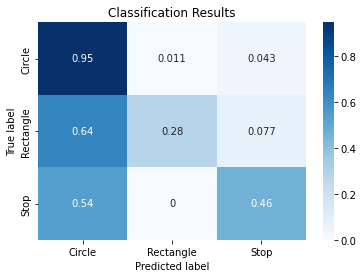

In [27]:
cm = metrics.confusion_matrix(df_found["class"], df_found["classification"])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure()

heatmap = sns.heatmap(cm, annot=True, cmap="Blues")

heatmap.xaxis.set_ticklabels(['Circle','Rectangle', 'Stop'])
heatmap.yaxis.set_ticklabels(['Circle','Rectangle', 'Stop'])

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Classification Results')

plt.show()    

### Extra: Save Results Table on a Webpage

In [28]:
from IPython.core.display import HTML

def append_images(row):
    return "output/concatenated/" + row.filename

def append_result(row):
    return row.classification is row["class"]

def path_to_image_html(path):
    return '<a target="_blank" href="' + path + '"><img src="'+ path + '" width="100" ></a>'


df["result"] = df.apply(append_result, axis=1)
df["image"] = df.apply(append_images, axis=1)

In [29]:
df = df.sort_values(by=['class'], ascending=False)
df.to_html('results.html', escape=False, formatters=dict(image=path_to_image_html))